In [39]:
using CSV, DataFrames
using Gurobi, JuMP
using PyPlot
using Statistics
rc("font", family = "Times New Roman")

In [2]:
features = ["timeCycles","setting1","setting2","T24","T30","T50","P30","Nf","Nc","Ps30","phi","NRf","NRc","BPR","htBleed","W31","W32"];

In [3]:
data = CSV.read("processed_data.csv", DataFrame)
first(data, 4)

Row,unitNumber,timeCycles,setting1,setting2,T24,T30,T50,P30,Nf,Nc,Ps30,phi,NRf,NRc,BPR,htBleed,W31,W32,RUL
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Float64,Float64,Int64
1,1,1,-0.0007,-0.0004,641.82,1589.7,1400.6,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.419,191
2,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.0,23.4236,190
3,1,3,-0.0043,0.0003,642.35,1587.99,1404.2,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
4,1,4,0.0007,0.0,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188


In [4]:
train = data[data[:, "unitNumber"] .<= 80, :]
test = data[data[:, "unitNumber"] .>80, :];

In [5]:
X_train, y_train = train[:, features], train[:, "RUL"]
X_test, y_test = test[:, features], test[:, "RUL"];

In [6]:
X_train_norm = (Matrix(X_train) .- minimum(Matrix(X_train), dims = 1)) ./ (maximum(Matrix(X_train), dims = 1) - minimum(Matrix(X_train), dims = 1))
X_test_norm = (Matrix(X_test) .- minimum(Matrix(X_train), dims = 1)) ./ (maximum(Matrix(X_train), dims = 1) - minimum(Matrix(X_train), dims = 1));

In [7]:
# Create learner object
lnr_rf = IAI.RandomForestRegressor(random_seed = 1)
# Perform a grid search using 5 folds
grid_rf = IAI.GridSearch(lnr_rf, max_depth = [5], num_trees = [100, 150])
IAI.fit!(lnr_rf, X_train_norm, y_train);
# Predict the target on the testing set
y_pred_rf = IAI.predict(grid_rf, X_test_norm);

[ Warning: This copy of Interpretable AI software is for academic purposes only and not for commercial use.
┌ Warning: Interpretable AI license expires soon: 2023-12-31T00:00:00. If you need to renew, please send us the following machine ID:
└ d84ef1ab9494bcee534a19010f7743c80bf6e7004b7dfb01b1b0f8c5d8f96aee


In [8]:
# Costs
Cs = 100
Cf = 1_000
Co = 100
costs = (Cs, Cf, Co)
# True risk parameters
alpha_true = 0.1;

In [9]:
# Failure probability function
function failure_probability(y, alpha)
    Pf = 2 ./ (1 .+ exp.(alpha * y))
    return Pf
end;

# function service_cost(y, alpha = 0.1)

#     Pf = 1 / (1 + exp.(- alpha * ))
#  #   Pf = (Pf - minimum(Pf)) / (maximum(Pf) - minimum(Pf))
#     return Pf
# end;

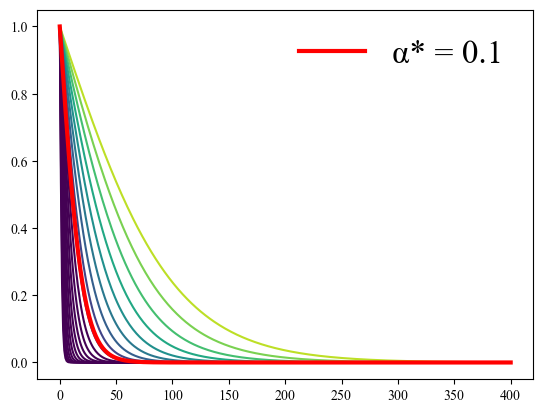

PyObject <matplotlib.legend.Legend object at 0x2c5ee5c90>

In [137]:
cmap_ = get_cmap("viridis_r")
xs = Vector(0:400)
alphas = exp.(range(log.(2e-2), 0, 20))
for (i, alpha) in enumerate(alphas)
    col = cmap_(i / 10)
    plot(xs, failure_probability(xs, alpha), color = col)
end
plot(xs, failure_probability(xs, 0.1), color = "r", linewidth = 3, label = "α* = 0.1")
legend(fontsize = 24, edgecolor = "w")

In [11]:
# Make prescriptions z {0,1} from predicted RULs and an assumed level of safety alpha
function prescriptions(y, alpha, costs)

    Cs, Cf, Co = costs
    n = length(y)
    model = Model(Gurobi.Optimizer)
    set_optimizer_attribute(model, "OutputFlag", 0)
    @variable(model, z[i = 1:n], Bin)
    @objective(model, Min, sum(Cs * z[i] + (1 - z[i]) * Cf * failure_probability(y[i], alpha) + z[i] * Co * y[i] for i = 1:n))
    optimize!(model)
    z = value.(z)
    return z # Return prescriptions
    
end;

In [12]:
# Return the cost components and total cost for some prescriptions, the true RULs and the true alpha
function cost(z, y_true, alpha_star, costs)
    Cs, Cf, Co = costs
    n = length(y_true)
    sc = sum(Cs * z[i] for i = 1:n)
    fc = sum((1 - z[i]) * Cf * failure_probability(y_true[i], alpha_star) for i = 1:n)
    oc = sum(Co * z[i] * y_true[i] for i = 1:n)
    return sc, fc, oc, sc + fc + oc
end;

In [13]:
function costs_with_alpha(y_pred, y_true, costs, alphas)

    ### costs with respect to assumed alpha ###
    Cs, Cf, Co = costs
    res = zeros(length(alphas), 4)

    for (i, alpha) in enumerate(alphas) 
        # Generate prescriptions from the predicted RULs
        z = prescriptions(y_pred, alpha, costs)
        # Evaluate the costs
        sc, fc, oc, tc = cost(z, y_true, 0.1, costs)
        res[i, :] = [sc, fc, oc, tc]
    end

    ### coefficient of prescriptiveness
    z_saa = prescriptions(repeat([mean(y_train)], length(y_test), 1), 0.1, costs)
    z_opt = prescriptions(y_test, 0.1, costs)
    _, _, _, TC_saa = cost(z_saa, y_test, 0.1, costs)
    _, _, _, TC_opt = cost(z_opt, y_test, 0.1, costs)

    z = prescriptions(y_pred, 0.1, costs)
    _, _, _, TC = cost(z, y_test, 0.1, costs)

    P = 1 - (TC - TC_opt) / (TC_saa - TC_opt)

    return res, P

end;

In [14]:
using ScikitLearn
@sk_import neighbors: KNeighborsClassifier;

[ Info: mkl not found, proceeding to installing non-mkl versions of sci-kit learn via Conda
[ Info: Running `conda install -y -c conda-forge 'scikit-learn>=1.2,<1.3'` in root environment
Error while loading conda entry point: conda-libmamba-solver (dlopen(/Users/martinbogaert/.julia/conda/3/aarch64/lib/python3.10/site-packages/libmambapy/bindings.cpython-310-darwin.so, 0x0002): Library not loaded: @rpath/libarchive.19.dylib
  Referenced from: <494304CB-2F24-3FF8-B4AE-F4E6B16BDC26> /Users/martinbogaert/.julia/conda/3/aarch64/lib/libmamba.2.0.0.dylib
  Reason: tried: '/Users/martinbogaert/.julia/conda/3/aarch64/lib/libarchive.19.dylib' (no such file), '/Users/martinbogaert/.julia/conda/3/aarch64/lib/python3.10/site-packages/libmambapy/../../../libarchive.19.dylib' (no such file), '/Users/martinbogaert/.julia/conda/3/aarch64/lib/python3.10/site-packages/libmambapy/../../../libarchive.19.dylib' (no such file), '/Users/martinbogaert/.julia/conda/3/aarch64/bin/../lib/libarchive.19.dylib' (no

Solving environment: ...working... done

# All requested packages already installed.



In [15]:
function w(idxNeighbors, k, n_test, n_train)
    weights = zeros(n_test, n_train);
    for i = 1:n_test
        for j in idxNeighbors[i,:]
            weights[i, j] = 1 / k
        end
    end
    return weights
end;

In [31]:
ks = Vector(5:10:800)
cs = []
for k in ks
    println(k)
    knn = KNeighborsClassifier(n_neighbors = k)
    # Train the classifier on the training data
    fit!(knn, Matrix(X_train_norm), Vector(y_train));

    ## Predict the nearest neighbors the testing set
    idxNeighbors = knn.kneighbors(Matrix(X_test_norm))[2] .+ 1

    weights = w(idxNeighbors, k, length(y_test), length(y_train))

    y_pred_knn = weights * y_train;

    z = prescriptions(y_pred_knn, 0.1, costs)
    # Best solution
    _, _, _, c = cost(z, y_test, 0.1, costs)
    push!(cs, c)
end

5
Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-18
15
Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-18
25
Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-18
35
Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-18
45
Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-18
55
Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-18
65
Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-18
75
Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-18
85
Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-18
95
Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-18
105
Set parameter Username
Academic license - for non-commerc

In [33]:
k = 50
knn = KNeighborsClassifier(n_neighbors = k)

# Train the classifier on the training data
fit!(knn, Matrix(X_train_norm), Vector(y_train));

## Predict the nearest neighbors the testing set
idxNeighbors = knn.kneighbors(Matrix(X_test_norm))[2] .+ 1

weights = w(idxNeighbors, k, length(y_test), length(y_train))

y_pred_knn = weights * y_train;

In [34]:
# Costs
Cs = 1000
Cf = 10000
Co = 50
costs = (Cs, Cf, Co)
# True risk parameters
alpha_true = 0.1;
alphas = exp.(range(log.(2e-2), 0, 100))

res_knn, P_knn = costs_with_alpha(y_pred_knn, y_test, costs, alphas);
res_perfect, P_opt = costs_with_alpha(y_test, y_test, costs, alphas);
res_saa, P_saa = costs_with_alpha(repeat([mean(y_train)], length(y_test), 1), y_test, costs, alphas);
res_pp_rf, P_rf = costs_with_alpha(y_pred_rf, y_test, costs, alphas);

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-18
Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-18
Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-18
Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-18
Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-18
Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-18
Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-18
Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-18
Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-18
Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-18
Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-18

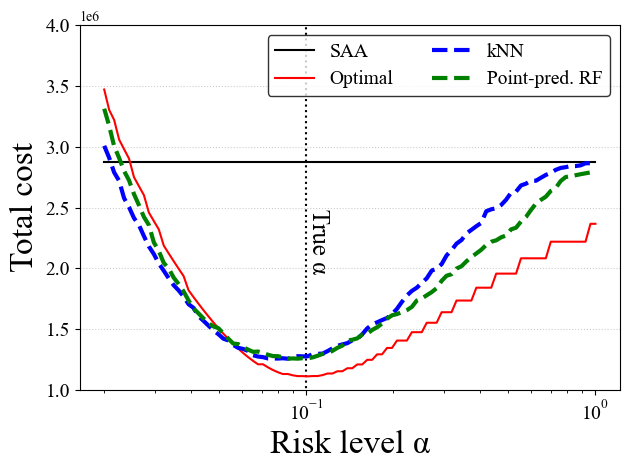

In [73]:
figure()
plot([0.1, 0.1], [0, 5e6], c = "k", linestyle = ":")
ylim([1e6, 4e6])
plot(alphas, res_saa[:, 4], c = "black", linestyle = "-", label = "SAA")
plot(alphas, res_perfect[:, 4], c = "red", linestyle = "-", label = "Optimal")
plot(alphas, res_knn[:, 4], c = "blue", linestyle = "--", linewidth = 3, label = "kNN")
plot(alphas, res_pp_rf[:, 4], c = "green", linestyle = "--", linewidth = 3, label = "Point-pred. RF")

grid(linestyle = ":", color = "k", alpha = 0.2, axis = "y")
ylabel("Total cost", size = 24)
xlabel("Risk level α", size = 24)
tick_params(axis = "both", labelsize = 14)
legend(edgecolor = "k", ncols = 2, fontsize = 14)
annotate(" True α", xy = (0.1, 2e6), rotation = 270, size = 18)

xscale("log")

tight_layout()
show()

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


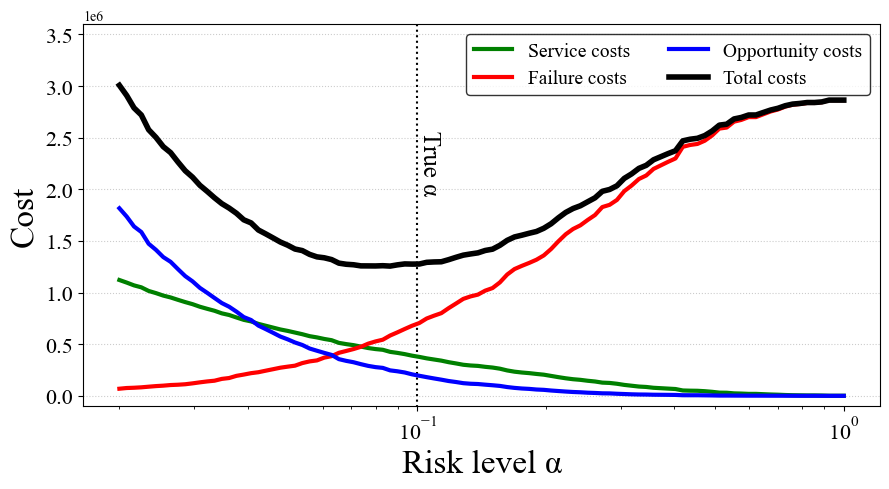

In [109]:
figure(figsize = (9, 5))
plot([0.1, 0.1], [-1e6, 5e6], c = "k", linestyle = ":")
ylim([-1e5, 3.6e6])
plot(alphas, res_knn[:, 1], c = "green", linestyle = "-", linewidth = 3, label = "Service costs")
plot(alphas, res_knn[:, 2], c = "red", linestyle = "-", linewidth = 3, label = "Failure costs")
plot(alphas, res_knn[:, 3], c = "blue", linestyle = "-", linewidth = 3, label = "Opportunity costs")
plot(alphas, res_knn[:, 4], c = "k", linestyle = "-", linewidth = 4, label = "Total costs")

grid(linestyle = ":", color = "k", alpha = 0.2, axis = "y")
ylabel("Cost", size = 24)
xlabel("Risk level α", size = 24)
tick_params(axis = "both", labelsize = 16)
legend(edgecolor = "k", ncols = 2, fontsize = 14, loc = "upper right")
annotate(" True α", xy = (0.1, 2e6), rotation = 270, size = 18)

xscale("log")

tight_layout()
savefig("costs_vs_risk_knn.jpeg", dpi = 400)
show()